<a href="https://colab.research.google.com/github/ashutosh3060/recipe-sales-forecast/blob/main/EDA_and_Model_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Table of Contents**

0. **Libraries**
1. **User-Defined Functions**
2. **Import Data**
3. **Exploratory Data Analysis**   
  3.1 Bivariate Analysis
        3.2.1 Continuous variables
        3.2.2 Multi-category categorical variables
  3.2 Multi-variate Analysis   
  3.3 Outlier Analysis   
        3.4.1 Boxplots     
        3.4.2 Scatter Plots
        3.4.3 IQR    
        3.4.4 Z-score   
  3.4 Correlation Matrix
4. **Data Preparation for Model Building**   
  4.1 Feature Selection    
  4.2 Train-Validation split  
5. **Model Build**  
  Train and prediction for various models   
6. **Hyperparameter Tuning**
7. **Cross Validation**   
  7.1 Based on Root mean squared error  
8. **Save the Best Model**
9. **Feature Importance**
10. **Ideas for Future work**

## 0. Libraries

In [1]:
# warnings
import warnings
warnings.filterwarnings("ignore")

# Dataframe, numerical exp and other python-native libraries
import time
from collections import Counter
import pickle
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# XGBoost
from xgboost import XGBRegressor, plot_importance

# imblearn for imbalanced data handling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Display Settings
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)

## 1. User-Defined Functions

In [2]:
def bivar_contns(df, contns_col, target):
    '''
    Plots the continuous variable's scatterplot with the target variable for the given dataframe

    Inputs
    ----------
    df : dataframe
        Dataframe containing Non-returning customers only
    contns_col : string
        Continuous variable name

    Output
    -------
    Scatterplot
        Scatterplot for the continuous variable and target variable
    '''
    plt.figure(figsize=(10,5))
    plt.title(f'{contns_col} & {target}')
    plt.xlabel(contns_col)
    plt.ylabel(target)
    sns.scatterplot(df[contns_col],df[target])
    plt.show()

def bivar_multi_cat(df, feature, target_ftr, label_rotation=False, horizontal_layout=True):
    '''
    Plots the multi-value categorical variable's bar-graph showing categories in x-axis and sales in y-axis

    Inputs
    ----------
    df : dataframe
        Dataframe containing Non-returning customers only
    feature : string
        Categorical variable name
    target_ftr : srtring
        Target variable name

    Output
    -------
    Bar-graph
        Bar graph: x-axis->Unique categories, y-axis->sales
    '''
    plt.figure(figsize=(8,6))
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Sales': temp.values})
    cat_perc = df[[feature, target_ftr]].groupby([feature],as_index=False).mean() # Calculate the percentage of target=1 per category value
    cat_perc.sort_values(by=target_ftr, ascending=False, inplace=True)
    sns.set_color_codes("pastel")
    s = sns.barplot(x = feature, y="Sales",data=df1)
    if(label_rotation):
        s.set_xticklabels('',rotation=60)
    s.set_title(feature)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

def bivar_binary_cat(df, feature, target_var):
    '''
    Plots Bar-graph using Cross-tab for binary categorical variable and target class

    Inputs
    ----------
    df : dataframe
        Dataframe containing Non-returning customers only
    feature : string
        Binary categorical variable name
    target_ftr : srtring
        Target variable name

    Output
    -------
    Bar-graph
        Bar graph: x-axis->target_ftr, y-axis->Binary categorical variable
    '''
    ct = pd.crosstab(df[target_var],df_order_label[feature]).apply(lambda r: round((r/r.sum())*100,1), axis=1)
    ct.plot.bar(stacked=True) 
    plt.xlabel(target_var)
    plt.ylabel(feature)
    plt.title(f"{target_var}  vs  {feature}") 
    plt.legend(bbox_to_anchor=(1.25,1.15), loc="upper right")
    plt.show()

def plot_roc(y_actual, y_pred):
    '''
    Plots the ROC curve and gives the ROC AUC value.

    Inputs
    ----------
    y_actual : Pandas Series
        Actual target value
    y_pred : Pandas Series
        Predicted target value out of model prediction

    Output
    -------
    ROC AUC Plot
        A graph showing False positive rate (x-axis) vs True positive rate (y-axis) for the target variable
        Range for Area under the curve value : 0 to 1 
                                              (0 being the worst and 1 being the best for predictive model)
    '''
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    roc_auc = roc_auc_score(y_actual, y_pred)
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='random')
    plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def perf_measure(y_actual, y_pred):
    '''
    Calculates the True Positive,  False Positive, True Negative,  False Negative values 

    Inputs
    ----------
    y_actual : Pandas Series
        Actual target value
    y_pred : Pandas Series
        Predicted target value out of model prediction

    Output
    -------
    TP, FP, TN, FN
        Number of records falling under 4 components of the confusion-matrix
    '''
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
            FP += 1
        if y_actual[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
            FN += 1

    return(TP, FP, TN, FN)

def capture_curve(df, y_actual, y_pred, roc, title):
    '''
    Plots the % of Actual Returning Customers captured out of overall customers, in each decile 

    Inputs
    ----------
    df : dataframe
        Dataframe having the population for which capture curve is to be plotted
    y_actual : Pandas Series
        Actual target value
    y_pred : Pandas Series
        Predicted target value out of model prediction
    roc : float
        ROC AUC value calculated from actual and predicted values
    title : string
        Title for the capture curve

    Output
    -------
    Capture curve
        A graph showing % of overall customers (from 1st to 10th decile) in x-axis and % of returning customers in y-axis
        Deciles are sorted (descending) based on predicted probability for customers being a returning customer in the next 6 months.
        1st decile -> 10th decile : Highest Probability -> Lowest probability
    '''
    fpr, tpr, threshold = roc_curve(y_actual, y_pred)
    roc_auc = auc(fpr, tpr)
    rate = []
    for i in threshold:
        T = perf_measure(list(y_actual),[1 if j >= i else 0 for j in y_pred])
        rate.append(T[0]+T[1])
    rate2 = [i/len(df) for i in rate]
    plt.figure(figsize=[12,12])
    plt.plot(rate2, tpr, label='ROC_AUC {}'.format(roc) % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('All Customers', fontsize=18)
    plt.ylabel('Captured out of total Returning proportion', fontsize=18)
    plt.title('Capture plot for {}'.format(title), fontsize=18)
    plt.legend(loc="lower right",prop={'size':30})
    plt.show()

def decile_cutoff_return_detected(df_pred, unique_id_name, target_act_name, target_pred_name):
    '''
    Returns the Dataframe with decile-wise count, percentage of returning customer and minimum, maximum and average predicted probability of each decile.

    Inputs
    ----------
    df_pred: Dataframe
        Dataframe with unique_id, actual and predicted(probability) value for the target
    unique_id_name: string
        unique identifier name in the dataframe
    target_act_name: string
        Actual target value name
    target_pred_name: string
        Predicted target value name

    Output
    -------
    Result Dataframe
        Dataframe with calculated fields
    '''
    pop_perc = list(np.arange(0.1,1.1,0.1))
    perc_list = []
    return_perc_list = []
    return_num_list = []
    avg_pred_prob_list = []
    min_pred_prob_list = []
    max_pred_prob_list = []
    df_pop_return = pd.DataFrame(columns=['customer_population_%', 'return_%', 'return_count', 'avg_pred_prob'])
    total_return_count = df_pred[df_pred[target_act_name]==1][unique_id_name].count()
    start = 0
    for perc in pop_perc:
        split_len = int(perc*len(df_pred))
        sorted_results_final = df_pred.iloc[start:split_len]
        return_count = sorted_results_final[sorted_results_final[target_act_name]==1][unique_id_name].count()
        min_pred_prob = sorted_results_final[target_pred_name].min()
        max_pred_prob = sorted_results_final[target_pred_name].max()
        avg_pred_prob = sorted_results_final[target_pred_name].mean()
        perc_list.append(int(perc*100))
        return_perc_list.append(round(((return_count/total_return_count)*100),2))
        return_num_list.append(round(return_count,2))
        min_pred_prob_list.append(round(min_pred_prob, 2))
        max_pred_prob_list.append(round(max_pred_prob, 2))
        avg_pred_prob_list.append(round(avg_pred_prob, 2))
        start = split_len
    df_pop_return['customer_population_%'] = perc_list
    df_pop_return['return_%'] = return_perc_list  
    df_pop_return['return_count'] = return_num_list
    df_pop_return['avg_pred_prob'] = avg_pred_prob_list
    df_pop_return['min_pred_prob'] = min_pred_prob_list
    df_pop_return['max_pred_prob'] = max_pred_prob_list
    return df_pop_return

def cum_decile_cutoff_return_detected(df_pred, unique_id_name, target_act_name, target_pred_name):
    '''
    Returns the Dataframe with decile-wise cumulative count, percentage of returning customer and cumulative minimum, maximum and average predicted probability of each decile.

    Inputs
    ----------
    df_pred: Dataframe
        Dataframe with unique_id, actual and predicted(probability) value for the target
    unique_id_name: string
        unique identifier name in the dataframe
    target_act_name: string
        Actual target value name
    target_pred_name: string
        Predicted target value name

    Output
    -------
    Result Dataframe
        Dataframe with calculated fields
    '''
    pop_perc = list(np.arange(0.1,1.1,0.1))
    perc_list = []
    return_perc_list = []
    return_num_list = []
    avg_pred_prob_list = []
    min_pred_prob_list = []
    max_pred_prob_list = []
    df_pop_return = pd.DataFrame(columns=['customer_population_%','cumulative_return_%', 'cumulative_return_count', 'avg_pred_prob'])
    total_return_count = df_pred[df_pred[target_act_name]==1][unique_id_name].count()
    for perc in pop_perc:
        split_len = int(perc*len(df_pred))
        sorted_results_final = df_pred.iloc[:split_len]
        return_count = sorted_results_final[sorted_results_final[target_act_name]==1][unique_id_name].count()
        min_pred_prob = sorted_results_final[target_pred_name].min()
        max_pred_prob = sorted_results_final[target_pred_name].max()
        avg_pred_prob = sorted_results_final[target_pred_name].mean()
        perc_list.append(int(perc*100))
        return_perc_list.append(round(((return_count/total_return_count)*100),2))
        return_num_list.append(round(return_count,2))
        min_pred_prob_list.append(round(min_pred_prob, 2))
        max_pred_prob_list.append(round(max_pred_prob, 2))
        avg_pred_prob_list.append(round(avg_pred_prob, 2))
    df_pop_return['customer_population_%'] = perc_list
    df_pop_return['cumulative_return_%'] = return_perc_list  
    df_pop_return['cumulative_return_count'] = return_num_list
    df_pop_return['avg_pred_prob'] = avg_pred_prob_list
    df_pop_return['min_pred_prob'] = min_pred_prob_list
    df_pop_return['max_pred_prob'] = max_pred_prob_list
    return df_pop_return

## 2. Import Data

In [3]:
# Define the path, filename

train_data_path = "/content/"
train_data_file = "train_data_transformed.csv"

test_data_path = "/content/"
test_data_file = "test_data_transformed.csv"

raw_train_data_path = "/content/"
raw_train_data_file = "train_data_cleaned.csv"

In [4]:
# import the dataset as a dataframe

df_train_data = pd.read_csv(train_data_path+train_data_file)
df_test_data = pd.read_csv(test_data_path+test_data_file)
raw_train_data = pd.read_csv(raw_train_data_path+raw_train_data_file)

In [5]:
# shape and first few records

print(df_train_data.shape)
df_train_data.head(3)

(2939, 21)


,year_week,week_num,recipe_id,recipe_name,calories,carbs,fat,number_of_ingredients_per_recipe,product_type_cat,cooking_time_cat,cuisine_cat,dish_type_cat,heat_level_cat,protein_cuts_cat,preferences_cat,carbs_content_cat,dish_types_cat,seasons_cat,protein_types_cat,meta_tags_cat,sales
0,201801,1,14919,Shrimp & Broccoli Stir-Fry,687.0,99.2,18.6,7,0,1,1,0,3,-1,39,31,11,0,32,0,3567
1,201801,1,14920,Caramelized Cabbage Pasta,779.0,81.3,38.5,5,0,1,20,2,1,8,29,24,49,0,24,10,2532
2,201801,1,14449,AFC Vegetarian Pad Thai,642.0,92.8,25.6,10,3,-1,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,6


## 3. Exploratory Data Analysis

In [6]:
# printing the first few records to define the structure of analysis

df_train_data.head()

,year_week,week_num,recipe_id,recipe_name,calories,carbs,fat,number_of_ingredients_per_recipe,product_type_cat,cooking_time_cat,cuisine_cat,dish_type_cat,heat_level_cat,protein_cuts_cat,preferences_cat,carbs_content_cat,dish_types_cat,seasons_cat,protein_types_cat,meta_tags_cat,sales
0,201801,1,14919,Shrimp & Broccoli Stir-Fry,687.0,99.2,18.6,7,0,1,1,0,3,-1,39,31,11,0,32,0,3567
1,201801,1,14920,Caramelized Cabbage Pasta,779.0,81.3,38.5,5,0,1,20,2,1,8,29,24,49,0,24,10,2532
2,201801,1,14449,AFC Vegetarian Pad Thai,642.0,92.8,25.6,10,3,-1,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,6
3,201801,1,11963,Shrimp & Broccoli Stir-Fry,620.0,93.2,13.7,7,2,1,1,0,3,-1,39,31,11,0,32,0,642
4,201801,1,14914,Chicken & Pasta Soup,610.0,67.0,20.0,7,2,1,20,1,1,0,36,39,84,0,30,0,1492


In [7]:
# Features

df_train_data.columns

Index(['year_week', 'week_num', 'recipe_id', 'recipe_name', 'calories',
       'carbs', 'fat', 'number_of_ingredients_per_recipe', 'product_type_cat',
       'cooking_time_cat', 'cuisine_cat', 'dish_type_cat', 'heat_level_cat',
       'protein_cuts_cat', 'preferences_cat', 'carbs_content_cat',
       'dish_types_cat', 'seasons_cat', 'protein_types_cat', 'meta_tags_cat',
       'sales'],
      dtype='object')

### 3.2 Bivariate Analysis

#### 3.2.1 **Continuous Variables**

1. Calories per recipe  
2. Carbs per recipe  
3. Fat per recipe  
4. Number of ingredients per recipe

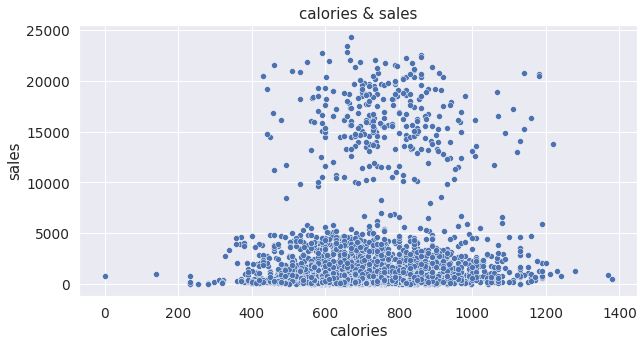

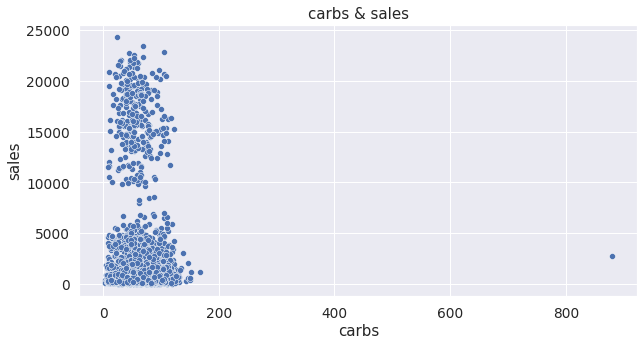

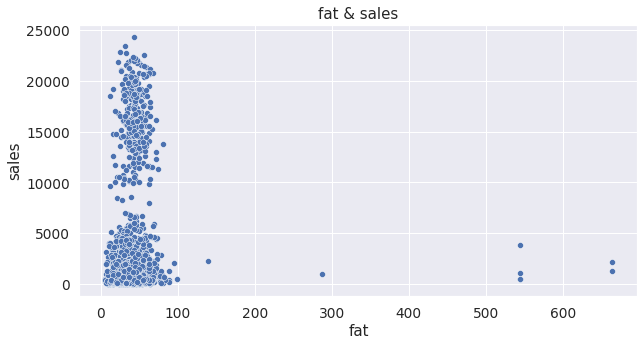

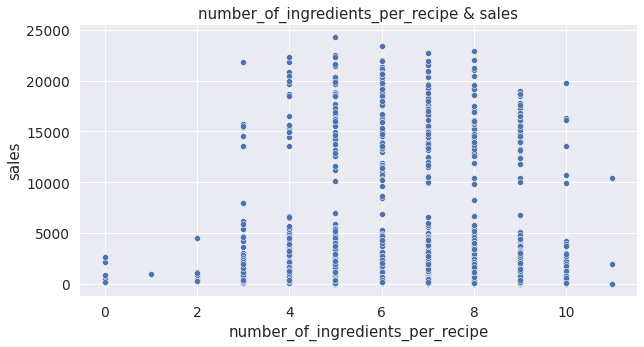

In [8]:
contns_vars = ["calories", "carbs", "fat", "number_of_ingredients_per_recipe"]
target = 'sales'

for var in contns_vars:
    bivar_contns(raw_train_data, var, target)

* **Sales** is **low** for **Number of ingredients** per recipe less than 3

#### 3.2.2 **Multi-category categorical variables**

1. Product type
2. Cooking time per recipe  
3. Cuisine    
4. Difficulty   
5. Dish type 
6. Heat level
7. is_classic
8. protein_cuts
9. preferences   
10. carbs_content    
11. dish_types   
12. seasons   
13. protein_types   
14. meta_tags   

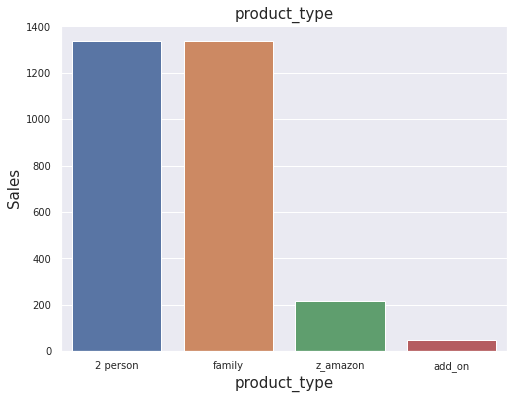

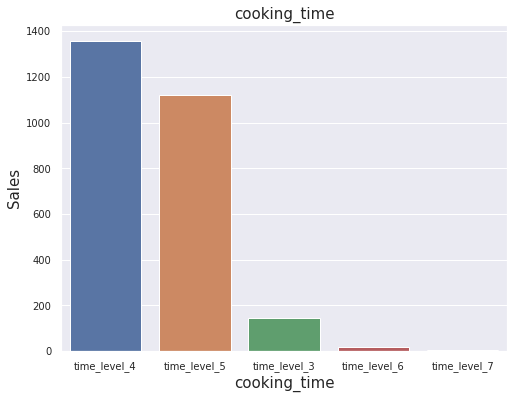

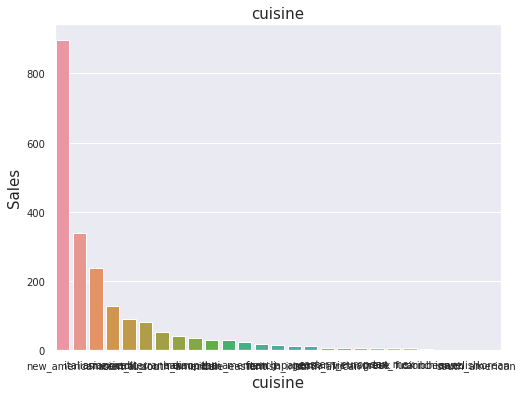

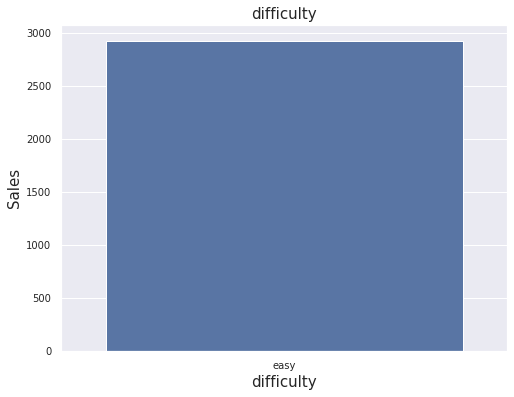

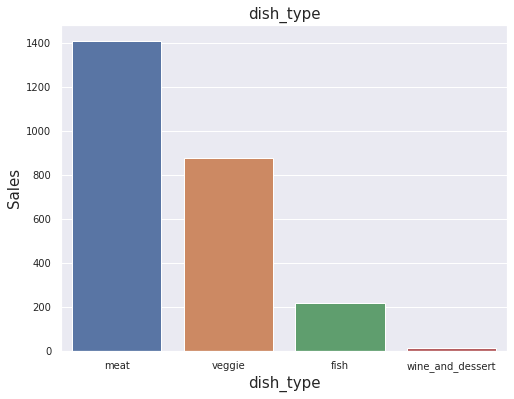

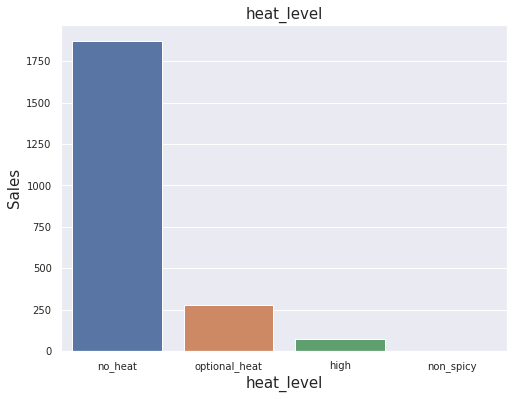

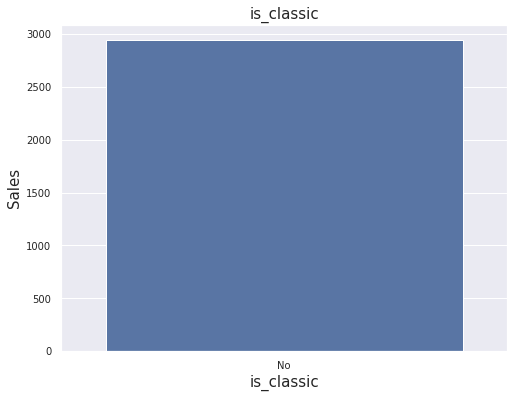

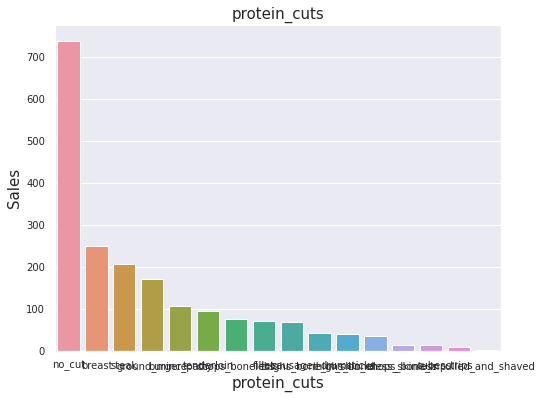

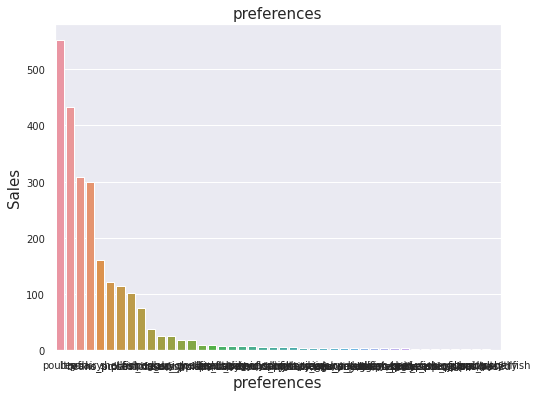

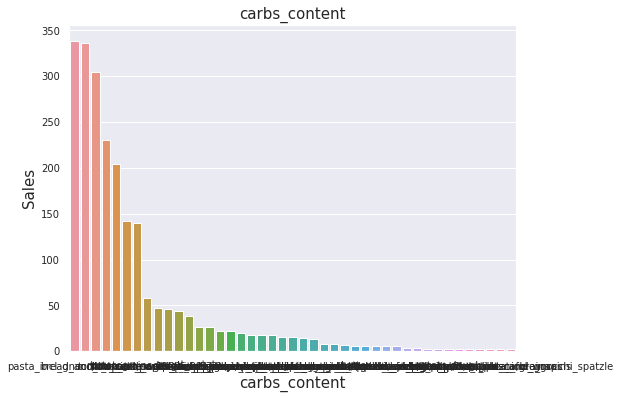

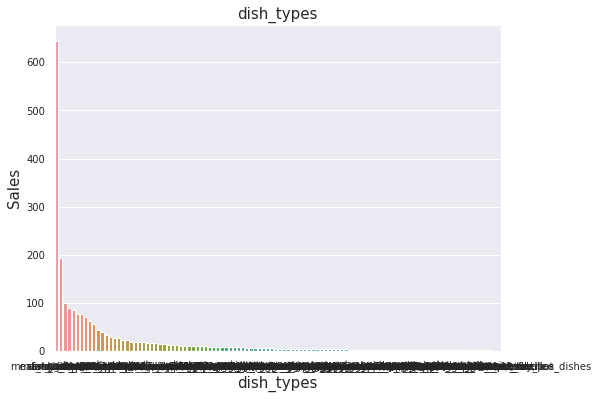

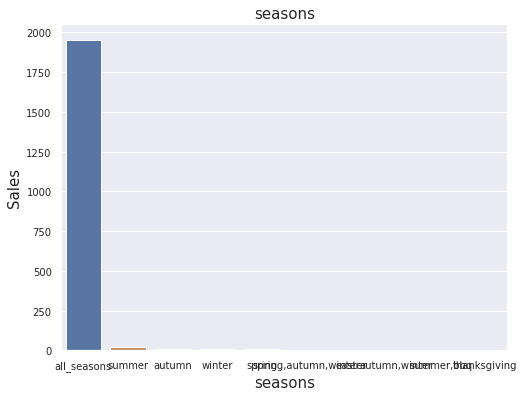

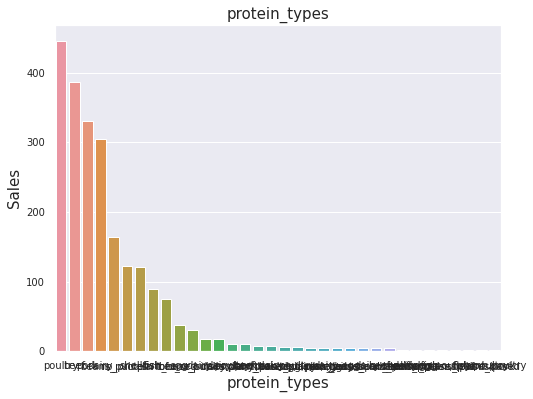

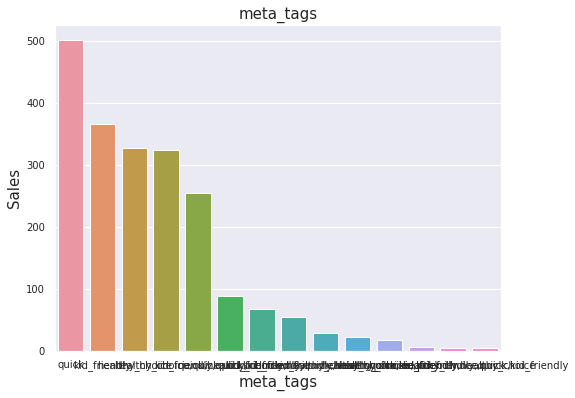

In [9]:
categorical_vars = [ "product_type", "cooking_time", "cuisine", "difficulty", "dish_type", "heat_level", "is_classic", "protein_cuts", 
                    'preferences', 'carbs_content', 'dish_types', 'seasons', 
                 'protein_types', 'meta_tags']
target_var = "sales"

for var in categorical_vars:
    bivar_multi_cat(raw_train_data, var, target_var, label_rotation=False, horizontal_layout=True)


* **is_classic**, **difficulty** variables are having only 1 value
* Need to rotate the x-axis for cuisine and protein_cuts for better readability
* Need to check, if number of recipes affect the sales distribution shown in the graph.

### 3.3 Multi-variate Analysis

**Will save it for future work**

### 3.4 Outlier Analysis

3.4.1 Boxplots        
3.4.2 Scatter Plots   
3.4.3 IQR    
3.4.4 Z-score     

* Scatter Plots and Z-score will do in future (due to time constraints)

#### 3.4.1 Boxplots

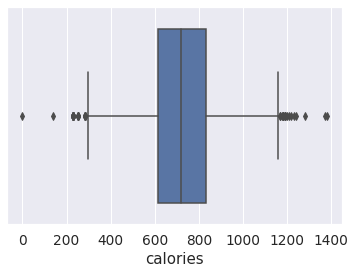

In [10]:
# boxplot for calories
sns.boxplot(x=df_train_data["calories"])
plt.show()

##### For all other continuous variables

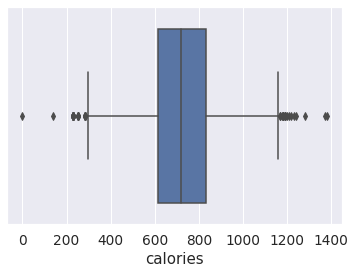

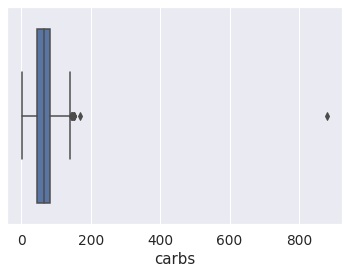

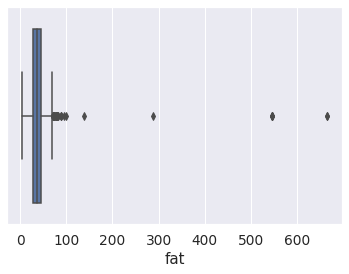

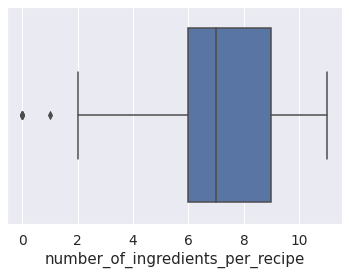

In [11]:
for var in contns_vars:
    sns.boxplot(x=df_train_data[var])
    plt.show()

* Need to dig deeper and before removing any values as outlier, need to check the final model's accuracy too.

#### 3.4.3 IQR Score

In [12]:
# Define Q1 and Q3 for IQR calculation

Q1 = df_train_data[contns_vars].quantile(0.25)
Q3 = df_train_data[contns_vars].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

calories                            217.5
carbs                                37.6
fat                                  17.3
number_of_ingredients_per_recipe      3.0
dtype: float64


In [13]:
# Calculate outlier percentage based on IQR concept

df_train_data_outlier = df_train_data[contns_vars][~((df_train_data[contns_vars] < (Q1 - 1.5 * IQR)) |(df_train_data[contns_vars] > (Q3 + 1.5 * IQR))).any(axis=1)]
outlier_percentage = (df_train_data_outlier.shape[0] / df_train_data[contns_vars].shape[0]) * 100
print(df_train_data[contns_vars].shape)
print(df_train_data_outlier.shape)
print(f"Outliuer percentage: {round(outlier_percentage,2)}")

(2939, 4)
(2841, 4)
Outliuer percentage: 96.67


* Saving these observations for future work
* Will check the model performance with and without outlier treatment
* Also some other methods such as **z-score**, **scatter-plot** can be tried further.

### 3.5 Correlation Matrix

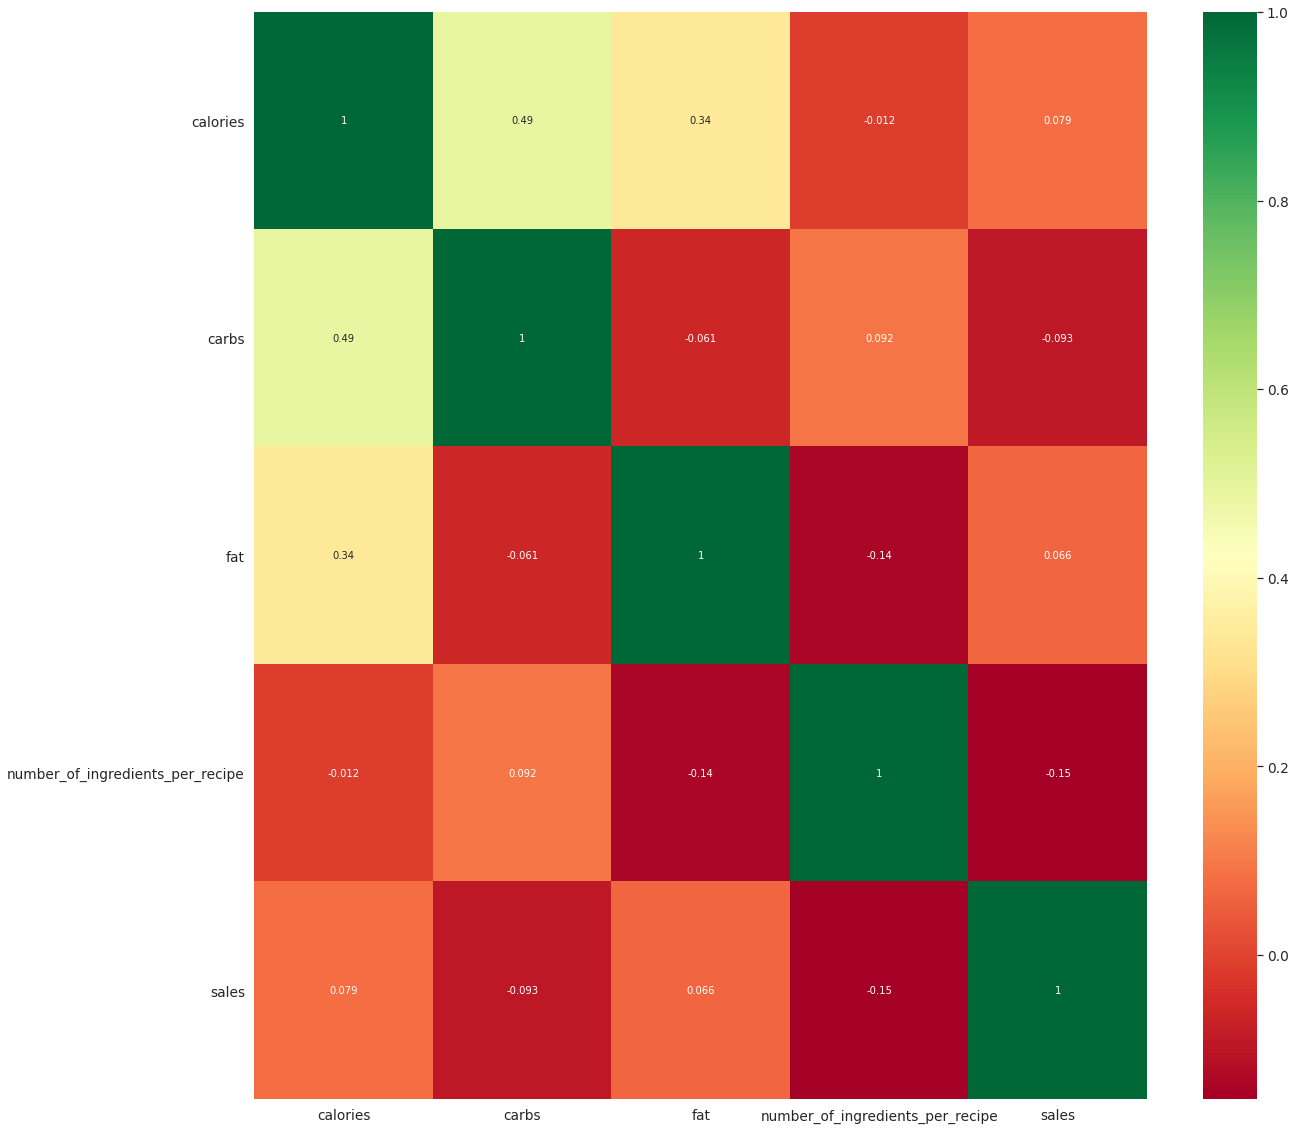

In [14]:
# Define all the variable set for correlation calculation
feature_set_corr = ["calories", "carbs", "fat", "number_of_ingredients_per_recipe", "sales"]

#get correlations of each features in dataset
corr_mat = raw_train_data[feature_set_corr].corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(raw_train_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

* The above correlation matrix helps in knowing the multicollinearity between independent variables.   
Here **carbs** and **calories** are correlated; but not very high, so will keep both.   
* Also it shows the correlation between independent and dependent variables.   
Correlation coefficients are very low for all the independent variables.

## 4. Data preparation for Model Build

In [15]:
df_train_data.columns

Index(['year_week', 'week_num', 'recipe_id', 'recipe_name', 'calories',
       'carbs', 'fat', 'number_of_ingredients_per_recipe', 'product_type_cat',
       'cooking_time_cat', 'cuisine_cat', 'dish_type_cat', 'heat_level_cat',
       'protein_cuts_cat', 'preferences_cat', 'carbs_content_cat',
       'dish_types_cat', 'seasons_cat', 'protein_types_cat', 'meta_tags_cat',
       'sales'],
      dtype='object')

In [16]:
# Define independent feature set and target variable

feature_set = ['week_num', 'calories', 'carbs', 'fat', 'number_of_ingredients_per_recipe', 
               'product_type_cat', 'cooking_time_cat', 'cuisine_cat', 'dish_type_cat', 'heat_level_cat', 
               'protein_cuts_cat', 'preferences_cat', 
                 'carbs_content_cat', 'dish_types_cat', 'seasons_cat', 
                 'protein_types_cat', 'meta_tags_cat']
target = 'sales'

In [17]:
# Define dataframe X and y for independent and dependent variables

X = df_train_data[feature_set]
y = df_train_data[target]

X_test = df_test_data[feature_set]
y_test = df_test_data[target]

### 4.1 Feature Selection

##### Techniques to try

1. ANOVA f-value
2. Check p-value, VIF, step-wise / cumulative accuracy for adding new features (*Logistic Regression*)
3. Feature Importance for Tree based models

1. ANOVA (For categorical traget variable)

In [18]:
# ANOVA feature selection for numeric input and categorical output

# define feature selection (Best 10 features based on f-value)
fs = SelectKBest(score_func=f_classif, k=10)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)
print(X_selected)

(2939, 10)
[[ 1.  18.6  0.  ... 31.  32.   0. ]
 [ 1.  38.5  0.  ... 24.  24.  10. ]
 [ 1.  25.6  3.  ... -1.  -1.  -1. ]
 ...
 [44.  37.   0.  ... 34.  22.   2. ]
 [44.  42.   0.  ... 14.  29.   5. ]
 [44.  47.   2.  ... 27.  30.   1. ]]


Need to check **step 2 and 3** while building Model pipeline

* In initial version of the model, I will feed all the features to train   
* Future-scope:   
Will remove features not significant from the feature selection concepts 2 and 3

### 4.2 Train-Validation split

In [19]:
# Insample train and validation split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train: {X_train.shape[0]}')
print(f'X_val: {X_val.shape[0]}')
print(f'y_train: {y_train.shape[0]}')
print(f'y_val: {y_val.shape[0]}')

X_train: 2351
X_val: 588
y_train: 2351
y_val: 588


In [20]:
# Create a validation dataframe using X_val and y_val for future evaluation metric calculation
df_val = pd.merge(df_train_data[["year_week", "recipe_id"]], pd.DataFrame(X_val), left_index=True, right_index=True, how='right')
df_val = pd.merge(df_val, pd.DataFrame(y_val), left_index=True, right_index=True, how='left')
print(df_val.shape)

# Create a list out of y_val (As y_val is a Pandas Series)
y_val_list = list(y_val)
print(len(y_val_list))

(588, 20)
588


In [21]:
# Create a validation dataframe using X_test and y_test for future evaluation metric calculation
df_test = pd.merge(df_test_data[["year_week", "recipe_id"]], pd.DataFrame(X_test), left_index=True, right_index=True, how='right')
df_test = pd.merge(df_test, pd.DataFrame(y_test), left_index=True, right_index=True, how='left')
print(df_test.shape)

# Create a list out of y_val (As y_test is a Pandas Series)
y_test_list = list(y_test)
print(len(y_test_list))

(320, 20)
320


In [22]:
df_val.head()

,year_week,recipe_id,week_num,calories,carbs,fat,number_of_ingredients_per_recipe,product_type_cat,cooking_time_cat,cuisine_cat,dish_type_cat,heat_level_cat,protein_cuts_cat,preferences_cat,carbs_content_cat,dish_types_cat,seasons_cat,protein_types_cat,meta_tags_cat,sales
2312,201929,13201,29,720.0,41.0,51.0,4,0,0,20,2,1,8,11,24,79,0,9,11,1150
650,201822,16353,22,683.0,77.6,34.9,5,0,2,1,2,1,8,29,31,105,0,24,3,1229
2602,201936,19673,36,700.0,28.0,50.0,6,0,2,20,1,1,11,7,35,14,0,6,-1,11414
177,201806,11700,6,830.0,68.0,44.0,7,2,2,20,-1,-1,-1,-1,-1,-1,-1,-1,-1,325
1340,201902,19117,2,710.0,60.0,42.0,7,0,2,20,0,1,-1,39,27,9,0,32,9,2370


## 5. Model Build

* Let's try different base models

* As the independent variables doesn't seem to be linear with the target variable, a linear model won't help much.
* Hence; I am planning to use different tree models for this problem 

In [23]:
## Seed
seed = 12

#### 1. Decision Tree

In [24]:
# Decision Tree Regressor

dtr = DecisionTreeRegressor(random_state=seed)
dtr.fit(X_train, y_train)
pred_val_dtr= dtr.predict(X_val)

print(np.round(np.sqrt(mean_squared_error(df_val["sales"], pred_val_dtr)),2))

5721.97


#### 2. Random Forest

In [25]:
# Random Forest Regressor

rfr = RandomForestRegressor(random_state=seed)
rfr.fit(X_train, y_train)
pred_val_rfr= rfr.predict(X_val)

print(np.round(np.sqrt(mean_squared_error(df_val["sales"], pred_val_rfr)),2))

4128.74


#### 5. XGBoost

In [26]:
# XGBoost Regressor

xgbr = XGBRegressor(random_state=seed, objective='reg:squarederror')
xgbr.fit(X_train, y_train)
pred_val_xgbr= xgbr.predict(X_val)

print(np.round(np.sqrt(mean_squared_error(df_val["sales"], pred_val_xgbr)),2))

3899.93


* RMSE is constantly decreasing from Decision Tree > Random Forest > XGBoost

* Let's tune the hyperparameter of XGBoost model with Gridsearch

In [27]:
# start_time=time.time()

# #### Create X and Y training data here.....


# # grid search
# model = XGBRegressor()

# param_grid = {
#         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#         'min_child_weight': [0.01, 0.05, 0.1, 0.5],
#         'gamma': [0, 10, 20, 40],
#         'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]}
#         # 'min_child_weight': np.arange(0.0001, 0.5, 0.001),
#         # 'gamma': np.arange(0.0,40.0,0.005),
#         # 'learning_rate': np.arange(0.0005,0.3,0.0005),
#         # 'subsample': np.arange(0.01,1.0,0.01),
#         # 'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01),2),
#         # 'colsample_bytree': np.arange(0.1,1.0,0.01)}

# kfold = KFold(n_splits=10, shuffle=True, random_state=10)
# grid_search = RandomizedSearchCV(model, param_grid, scoring="accuracy", n_iter = 500, cv=kfold)
# grid_result = grid_search.fit(X_train,y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_[ 'mean_test_score' ]
# stds = grid_result.cv_results_[ 'std_test_score' ]
# params = grid_result.cv_results_[ 'params' ]

# print(time.time()-start_time) 

* In future, I can try tuning hyperparameters as it takes good amount of time

* Let's try a random model and see if it is better than default model

In [28]:
### XGBoost Model with random parameters

random_xgb = XGBRegressor(learning_rate =0.01,
 n_estimators=100,
 max_depth=5,
 min_child_weight=6,
 gamma=0,
 subsample=0.84,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'reg:squarederror',
 seed=seed)

# train the random model
random_xgb.fit(X_train, y_train)
# prediction
pred_val_random_xgb = random_xgb.predict(X_val)

print(np.round(np.sqrt(mean_squared_error(df_val["sales"], pred_val_random_xgb)),2))

4252.05


In [29]:
# Cross-check the model's hyperparameters
pprint(random_xgb.get_params)

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=6, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1,
             seed=12, silent=None, subsample=0.84, verbosity=1)>


## 7. Cross Validation

### 7.1 Based on F1 Score (5-fold)

In [30]:
# Compute cross-validated root mean squared error on training data
cv_5_f1_xgbr = cross_val_score(xgbr, X_train, y_train, cv=5, scoring = 'neg_root_mean_squared_error')

# Print list of AUC scores
print("Root mean squared error computed using 5-fold cross-validation: {}".format(cv_5_f1_xgbr))

Root mean squared error computed using 5-fold cross-validation: [-3855.8820845  -3681.01843471 -3832.464224   -4062.31908389
 -4004.19280953]


* Root mean squared error variance quite low.  
(Here the cross_val_score has negative mean_squared_error. So converting the negative values to +ve is required)

* Hence this model can be cosidered as the final model (Also the random model  is not the best model)

## 8. Save the Best Model

In [31]:
# save the model as a pickle file

filename = 'xgboost_v1'
pickle.dump(xgbr, open(filename, 'wb'))

In [32]:
# Cross verify the prediction from saved model

recipe_sales_forecast_model = pickle.load(open('xgboost_v1', 'rb'))
pred_val_recipe_sales = recipe_sales_forecast_model.predict(X_val)
# rmse claculation
print(np.round(np.sqrt(mean_squared_error(df_val["sales"], pred_val_recipe_sales)),2))

3899.93


* Saving the model as a pickle file, loading and predicting is working fine.

## Test Data Prediction

In [33]:
df_prediction = df_test.copy()
pred_val_recipe_sales_test = recipe_sales_forecast_model.predict(X_test)
df_prediction['predicted_sales']=list(pred_val_recipe_sales_test)
print(df_prediction.shape)
df_prediction.head()
df_prediction_final = df_prediction[["recipe_id", "year_week", "predicted_sales"]]
print(df_prediction_final.shape)
df_prediction_final.head(5)

(320, 21)
(320, 3)


,recipe_id,year_week,predicted_sales
0,38287,201945,5920.214355
1,38309,201945,5080.641602
2,38310,201945,1269.440430
3,38311,201945,5754.139648
4,38312,201945,1225.266602


In [34]:
# Export the dataframe to a csv
df_prediction_final.to_csv('sales_prediction.csv', index=False)

## 9. Feature Importance

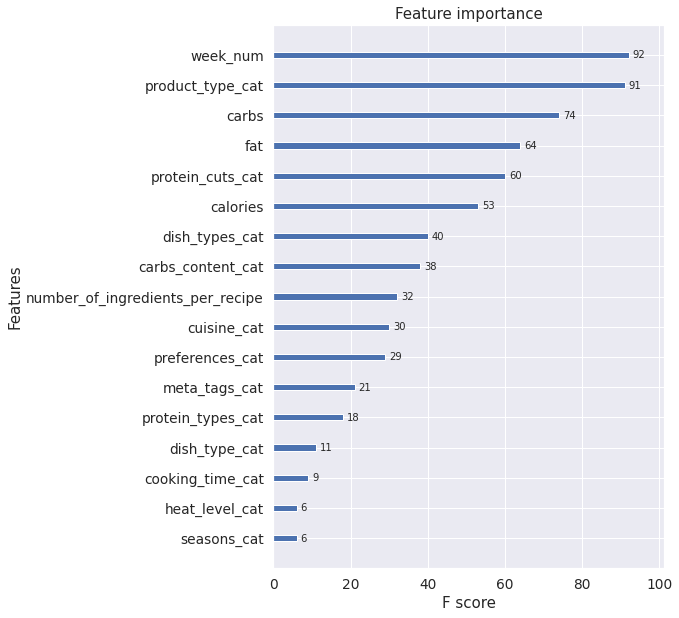

In [35]:
# Feature Importance plot for XGBoost

plt.rcParams["figure.figsize"] = (7, 10)
plot_importance(recipe_sales_forecast_model)
plt.show()

* **week number** and **product type** are the most important feature.

#### Other Important features:

1. carbs   
2. fat    
3. protein_cuts   
4. calories   

## 10. Ideas for Future work

1. Build 2 Different segment models for High and Low sales.   
Need to check the accuracy of these 2 meta models. If better need to replace the model which is built on overall dataset.

2. Try other Other ML techniques.
* Multi-variate Analysis
* Proper Outlier Analysis
* Hyperparameter tuning for XGBoost algorithm.
* Try LightGBM and tune its parameters.

3. Evaluation and statistical parameter checks
* p-values, adjusted R^2, VIF for independent features
* Learning curve for adding more data

*************************************************
*************************************************